In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GRUSubunit(nn.Module):
    def __init__(self, in_no, H_no, batch_first):
        super().__init__()
        
        self.in_no = in_no
        self.H_no = H_no
        self.batch_first = batch_first
        self.rnn = nn.GRU(in_no, H_no, batch_first=batch_first)
        self.lin = nn.Linear(H_no, 1)
        
    def forward(self, input):
        batch_size = input.shape[0]
        T_data = input.shape[1]
        
        out, _ = self.rnn(input)
        out = self.lin(out.reshape(-1,self.H_no)).reshape(batch_size, T_data)
        return out

class FiltGRU(nn.Module):
    def __init__(self, H_no, E_no, I_no, sub_no, T_no, C_syn_e, C_syn_i, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        self.sub_no = sub_no
        self.C_syn_e = C_syn_e
        self.C_syn_i = C_syn_i
        self.E_no = E_no
        self.I_no = I_no
        self.T_no = T_no
        
        self.E_scale = nn.Parameter(torch.zeros(self.E_no), requires_grad=True)
        self.I_scale = nn.Parameter(torch.zeros(self.I_no), requires_grad=True)
        
        self.subunit = GRUSubunit(1, self.H_no, True)
        self.kern_raw = nn.Parameter(torch.zeros(sub_no, T_no), requires_grad=True)
        
    def forward(self, S_e, S_i):
        T_data = S_e.shape[1]
        batch_size = S_e.shape[0]
        S_e = S_e * torch.exp(self.E_scale.reshape(1,1,-1))
        S_i = S_i * torch.exp(self.I_scale.reshape(1,1,-1))*(-1)
        
        S_e_sub = torch.matmul(S_e, self.C_syn_e.T.unsqueeze(0))
        S_i_sub = torch.matmul(S_i, self.C_syn_i.T.unsqueeze(0))
        S_sub = S_e_sub + S_i_sub
        
        sub_out_raw = torch.zeros(batch_size, T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            part_out = self.subunit(S_sub[:,:,s].unsqueeze(2))
            sub_out_raw[:,:,s] = sub_out_raw[:,:,s] + part_out 
            
        sub_out_raw = sub_out_raw.permute(0,2,1) #(B,sub,T)
        sub_out_raw_pad = torch.zeros(batch_size, self.sub_no, T_data+self.T_no-1).to(self.device)
        sub_out_raw_pad[:,:,-T_data:] = sub_out_raw_pad[:,:,-T_data:] + sub_out_raw
        
        kern = torch.sigmoid(self.kern_raw).unsqueeze(1)
        sub_out = F.conv1d(sub_out_raw_pad, kern, groups=self.sub_no).permute(0,2,1)
        final = torch.sum(sub_out, 2)
        
        return final, sub_out


In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

part_C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_e.npy")
part_C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_i.npy")
part_C_syn_e = torch.from_numpy(part_C_syn_e)
part_C_syn_i = torch.from_numpy(part_C_syn_i)

In [4]:
T_train = 994 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 500
H_no = 10
layer_no = 1
sub_no = 10
E_no = 2000
I_no = 200
device = torch.device("cuda")

batch_length = 50000
batch_size = 7
iter_no = 9940
epoch_no = iter_no*batch_length*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_e[:6] = part_C_syn_e

C_syn_i = torch.zeros(sub_no, I_no).to(device)
C_syn_i[:6] = part_C_syn_i

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1

In [7]:
model = FiltGRU(H_no, E_no, I_no, sub_no, T_no, C_syn_e, C_syn_i, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.75)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

7601


In [ ]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _ = model(batch_E_neural[:,10000:40000], batch_I_neural[:,10000:40000])
    
    loss = torch.mean((V_pred - batch_V[:,10000:40000])**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(test_E_neural[10000:40000].unsqueeze(0), test_I_neural[10000:40000].unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[10000:40000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[10000:40000]-test_V_pred)**2).item()
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-8-de7c31b5f489>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -8.875716 4555.828125
49 -0.029643 8.875767
99 0.114929 2.361011
149 0.210395 2.079292
199 0.289437 1.871902
249 0.353393 1.702978
299 0.407563 1.561066
349 0.454799 1.437494
399 0.493644 1.333406
449 0.527333 1.250931
499 0.552416 1.179926
549 0.57324 1.123893
599 0.588134 1.093269
649 0.600375 1.063727
699 0.61095 1.026079
749 0.618172 1.029484
799 0.625486 1.002024
849 0.632677 0.967946
899 0.638015 0.953565
949 0.642306 0.94711
999 0.647649 0.933933
1049 0.651431 0.917944
1099 0.65507 0.911102
1149 0.657935 0.97167
1199 0.662242 0.891272


In [9]:
#.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat.pt")

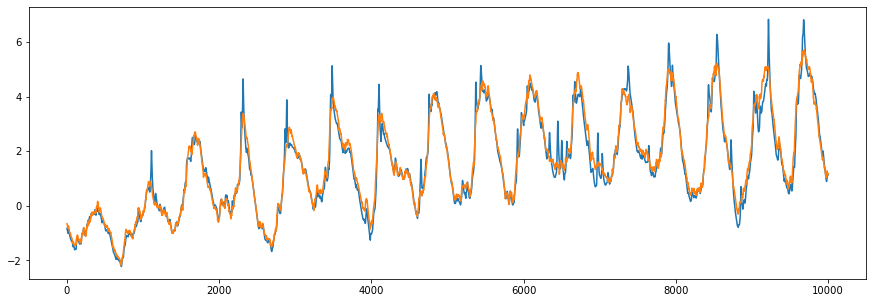

In [22]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:40000][6000:16000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000])

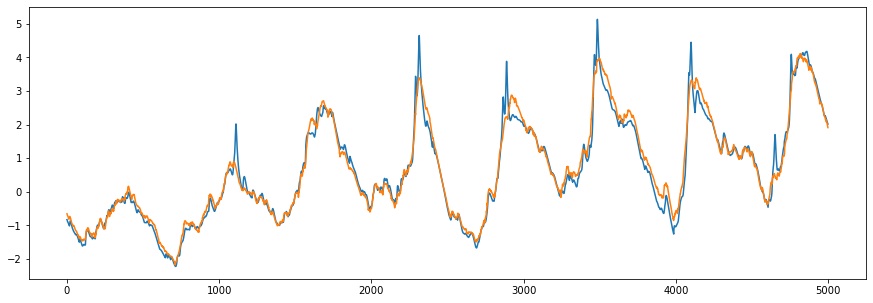

In [23]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:40000][6000:16000][:5000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000][:5000])

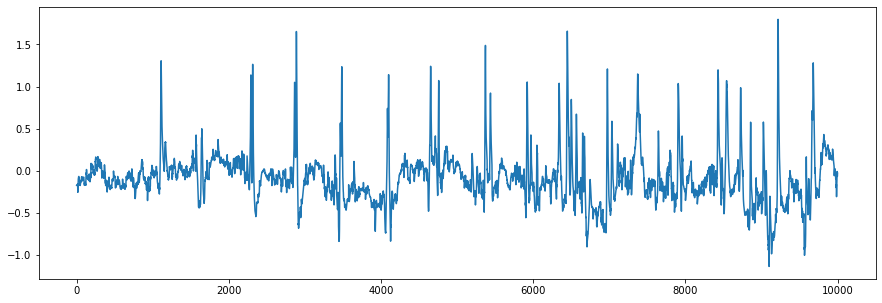

In [24]:
diff = V_test[10000:40000] - test_V_pred

plt.figure(figsize = (15,5))
plt.plot(diff.cpu().detach().numpy()[6000:16000])